### Install libraries

In [1]:
!pip3 install google-cloud-bigquery==3.25.0 -U
!pip install google-cloud-aiplatform==1.59.0
!pip uninstall -y shapely pygeos geopandas
!pip install shapely==1.8.5.post1 pygeos==0.12.0 geopandas>=0.12.2
# Install pydot and graphviz
!pip install pydot
!sudo apt install graphviz -y

  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.4.2
    Uninstalling google-cloud-bigquery-3.4.2:
      Successfully uninstalled google-cloud-bigquery-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.9.0 requires google-cloud-resource-manager>=1.10.3, but you have google-cloud-resource-manager 1.8.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.22.0
    Uninstalling google-cloud-aiplatform-1.22.0:
      Successfully uninstalled google-cloud-aiplatform-1.22.0
Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1
Found existing installation: geopandas 1.0.1
Un

In [2]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

# Definir variables y buckets

In [1]:
PATH=%env PATH

In [2]:
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [3]:
!gcloud config list

[compute]
region = us-central1
[core]
account = 112095732669-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = kaggle-competitions-442514
[dataproc]
region = us-central1

Your active configuration is: [default]


In [54]:
PROJECT_ID = "kaggle-competitions-442514"
REGION = "us-central1"
GCS_BUCKET = f"gs://{PROJECT_ID}"

In [5]:
!gcloud storage buckets create -l $REGION $GCS_BUCKET

Creating gs://kaggle-competitions-442514/...
ERROR: (gcloud.storage.buckets.create) HTTPError 409: Your previous request to create the named bucket succeeded and you already own it.


# Importar Librerías

In [5]:
import os
import shutil
import logging


import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

# Re-create the AdamW optimizer 
from official.nlp import optimization  

# Libraries for data and plot model training metrics.
import pandas as pd
import matplotlib.pyplot as plt

# Import the Vertex AI Python SDK.
from google.cloud import aiplatform as vertexai

2025-01-08 11:43:00.494299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

# Dataset

 Data source used: [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment) 

### Import Dataset

In [7]:
DATA_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
LOCAL_DATA_DIR = "."

In [8]:
def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname="aclImdb_v1.tar.gz",
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
    
    train_dir = os.path.join(dataset_dir, "train")
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, "unsup")
    shutil.rmtree(remove_dir)
    
    return dataset_dir

In [9]:
DATASET_DIR = download_data(data_url=DATA_URL, local_data_dir=LOCAL_DATA_DIR)

84125825/84125825 [==============================] - 8s 0us/step


# Definicion y del modelo

In [10]:
HPARAMS = {
    # Set a random sampling seed to prevent data leakage in data splits from files.
    "seed": 42,
    # Number of training and inference examples.
    "batch-size": 32
}

In [11]:
def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds

In [12]:
raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, HPARAMS)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = raw_train_ds.class_names

train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review {i}: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({CLASS_NAMES[label]})')

Review 0: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review 1: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as 

In [15]:
HPARAMS.update({
    # TF Hub BERT modules.
    "tfhub-bert-preprocessor": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "tfhub-bert-encoder": "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
})

In [16]:
HPARAMS.update({
    # Model training hyperparameters for fine tuning and regularization.
    "epochs": 2,
    "initial-learning-rate": 3e-5,
    "dropout": 0.1 
})

In [17]:
epochs = HPARAMS['epochs']
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
n_train_steps = steps_per_epoch * epochs
n_warmup_steps = int(0.1 * n_train_steps)    

OPTIMIZER = optimization.create_optimizer(init_lr=HPARAMS['initial-learning-rate'],
                                          num_train_steps=n_train_steps,
                                          num_warmup_steps=n_warmup_steps,
                                          optimizer_type='adamw')

In [18]:
def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor=hub.KerasLayer(HPARAMS["tfhub-bert-preprocessor"], name='preprocessing')
    
    encoder_inputs = preprocessor(text_input)
    encoder= hub.KerasLayer(HPARAMS["tfhub-bert-encoder"], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    classifier = outputs['pooled_output']
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model

In [19]:
model = build_text_classifier(HPARAMS, OPTIMIZER)

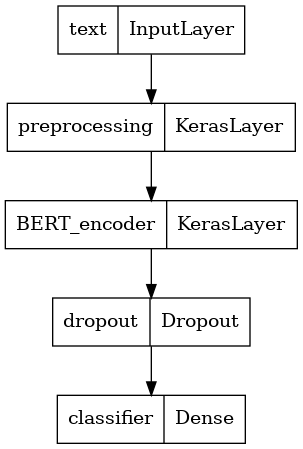

In [20]:
tf.keras.utils.plot_model(model)

##

In [33]:
def build_text_classifier_v2(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier with additional layers.
    Args:
      hparams(dict): A dictionary containing model training arguments.
      optimizer: Optimizer for training the model.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    # Input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # Preprocessing with BERT preprocessor
    preprocessor = hub.KerasLayer(hparams["tfhub-bert-preprocessor"], name='preprocessing')
    encoder_inputs = preprocessor(text_input)
    
    # BERT encoder
    encoder = hub.KerasLayer(hparams["tfhub-bert-encoder"], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Extract pooled output and sequence output
    pooled_output = outputs['pooled_output']  # [CLS] token representation
    sequence_output = outputs['sequence_output']  # All tokens representations
    
    # Add a GlobalAveragePooling layer for sequence output
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    
    # Concatenate pooled output and global average pooling
    concatenated = tf.keras.layers.Concatenate(name='concatenate_features')([pooled_output, global_avg_pooling])
    
    # Optional: Add BatchNormalization
    normalized = tf.keras.layers.BatchNormalization(name='batch_normalization')(concatenated)
    
    # Fully connected layer 1 with L2 regularization
    dense_1 = tf.keras.layers.Dense(
        256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1'
    )(normalized)
    dropout_1 = tf.keras.layers.Dropout(hparams['dropout'], name='dropout_1')(dense_1)
    
    # Fully connected layer 2
    dense_2 = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(hparams['dropout'], name='dropout_2')(dense_2)
    
    # Output layer
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(dropout_2)
    
    # Define the model
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    # Compile the model
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
    
    return model


In [31]:
model_v2 = build_text_classifier_v2(HPARAMS, OPTIMIZER)

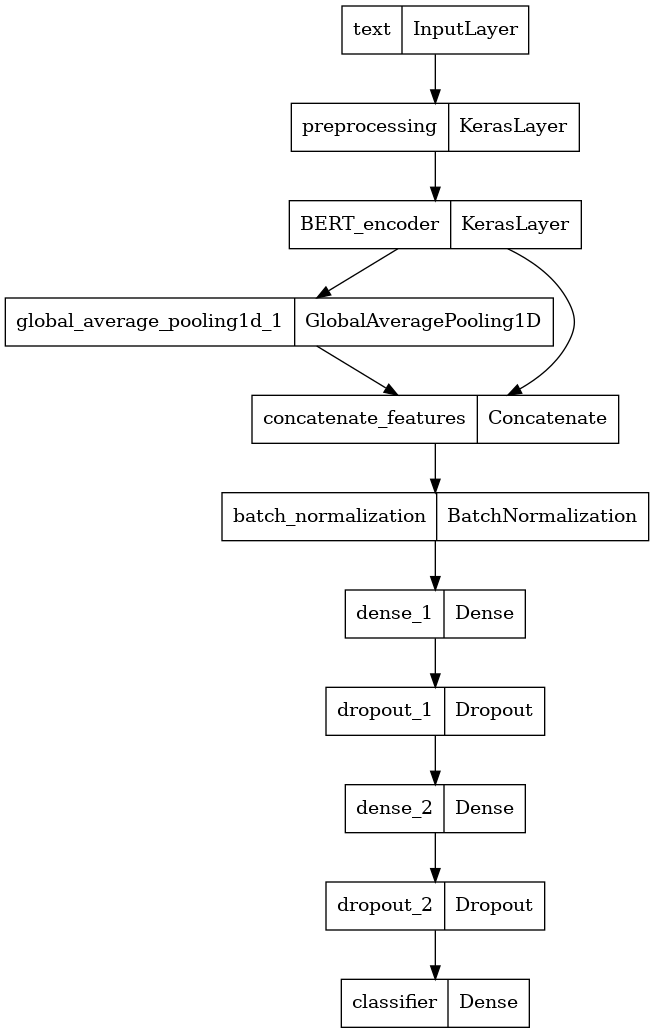

In [32]:
tf.keras.utils.plot_model(model_v2)

In [34]:
TEST_REVIEW = ['this is such an amazing movie!']

In [35]:
BERT_RAW_RESULT = model(tf.constant(TEST_REVIEW))
print(BERT_RAW_RESULT)

tf.Tensor([[0.44103754]], shape=(1, 1), dtype=float32)


In [40]:
HPARAMS.update({
    'model-dir': os.path.join('./bert-sentiment-classifier-local')
    
})

In [39]:
def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    # dataset_dir = download_data(data_url, local_data_dir)
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(DATASET_DIR, hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
    
    logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

# Contenerización del entrenamiento

Repository structure:
```
|--/bert-sentiment-classifier
   |--/trainer
      |--__init__.py
      |--model.py
      |--task.py
   |--Dockerfile
   |--cloudbuild.yaml
   |--requirements.txt
```

In [23]:
MODEL_DIR = "bert-sentiment-classifier"

In [45]:
%%writefile {MODEL_DIR}/trainer/model.py
import os
import shutil
import logging

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

DATA_URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
LOCAL_DATA_DIR = './tmp/data'
AUTOTUNE = tf.data.AUTOTUNE


def download_data(data_url, local_data_dir):
    """Download dataset.
    Args:
      data_url(str): Source data URL path.
      local_data_dir(str): Local data download directory path.
    Returns:
      dataset_dir(str): Local unpacked data directory path.
    """
    if not os.path.exists(local_data_dir):
        os.makedirs(local_data_dir)
    
    dataset = tf.keras.utils.get_file(
      fname='aclImdb_v1.tar.gz',
      origin=data_url,
      untar=True,
      cache_dir=local_data_dir,
      cache_subdir="")
    
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    train_dir = os.path.join(dataset_dir, 'train')
    
    # Remove unused folders to make it easier to load the data.
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
    
    return dataset_dir


def load_datasets(dataset_dir, hparams):
    """Load pre-split tf.datasets.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      raw_train_ds(tf.dataset): Train split dataset (20k examples).
      raw_val_ds(tf.dataset): Validation split dataset (5k examples).
      raw_test_ds(tf.dataset): Test split dataset (25k examples).
    """    

    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='training',
        seed=hparams['seed'])    

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        batch_size=hparams['batch-size'],
        validation_split=0.2,
        subset='validation',
        seed=hparams['seed'])

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        batch_size=hparams['batch-size'])
    
    return raw_train_ds, raw_val_ds, raw_test_ds


def build_text_classifier(hparams, optimizer):
    """Define and compile a TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      model(tf.keras.Model): A compiled TensorFlow model.
    """
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor=hub.KerasLayer(HPARAMS["tfhub-bert-preprocessor"], name='preprocessing')
    
    encoder_inputs = preprocessor(text_input)
    encoder= hub.KerasLayer(HPARAMS["tfhub-bert-encoder"], trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    classifier = outputs['pooled_output']
    # Add dropout to prevent overfitting during model fine-tuning.
    classifier = tf.keras.layers.Dropout(hparams['dropout'], name='dropout')(classifier)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier)
    model = tf.keras.Model(text_input, classifier, name='bert-sentiment-classifier')
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)    
    
    return model


def train_evaluate(hparams):
    """Train and evaluate TensorFlow BERT sentiment classifier.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    dataset_dir = download_data(data_url=DATA_URL, 
                                local_data_dir=LOCAL_DATA_DIR)
    
    raw_train_ds, raw_val_ds, raw_test_ds = load_datasets(dataset_dir=dataset_dir,
                                                          hparams=hparams)
    
    train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)     
    
    epochs = hparams['epochs']
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    n_train_steps = steps_per_epoch * epochs
    n_warmup_steps = int(0.1 * n_train_steps)    
    
    optimizer = optimization.create_optimizer(init_lr=hparams['initial-learning-rate'],
                                              num_train_steps=n_train_steps,
                                              num_warmup_steps=n_warmup_steps,
                                              optimizer_type='adamw')    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = build_text_classifier(hparams=hparams, optimizer=optimizer)
        logging.info(model.summary())
        
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)  
    
    logging.info("Test accuracy: %s", model.evaluate(test_ds))

    # Export Keras model in TensorFlow SavedModel format.
    model.save(hparams['model-dir'])
    
    return history

Writing bert-sentiment-classifier/trainer/model.py


In [46]:
%%writefile {MODEL_DIR}/trainer/task.py

import os
import argparse

from trainer import model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Vertex custom container training args. These are set by Vertex AI during training but can also be overwritten.
    parser.add_argument('--model-dir', dest='model-dir',
                        default=os.environ['AIP_MODEL_DIR'], type=str, help='GCS URI for saving model artifacts.')

    # Model training args.
    parser.add_argument('--tfhub-bert-preprocessor', dest='tfhub-bert-preprocessor', 
                        default='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', type=str, help='TF-Hub URL.')
    parser.add_argument('--tfhub-bert-encoder', dest='tfhub-bert-encoder', 
                        default='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', type=str, help='TF-Hub URL.')    
    parser.add_argument('--initial-learning-rate', dest='initial-learning-rate', default=3e-5, type=float, help='Learning rate for optimizer.')
    parser.add_argument('--epochs', dest='epochs', default=2, type=int, help='Training iterations.')    
    parser.add_argument('--batch-size', dest='batch-size', default=32, type=int, help='Number of examples during each training iteration.')    
    parser.add_argument('--dropout', dest='dropout', default=0.1, type=float, help='Float percentage of DNN nodes [0,1] to drop for regularization.')    
    parser.add_argument('--seed', dest='seed', default=42, type=int, help='Random number generator seed to prevent overlap between train and val sets.')
    
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_evaluate(hparams)

Writing bert-sentiment-classifier/trainer/task.py


In [48]:
%%writefile {MODEL_DIR}/Dockerfile

FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11:latest


WORKDIR /root

COPY requirements.txt .

RUN pip3 install -U -r requirements.txt
RUN rm -rf /var/sitecustomize/sitecustomize.py

COPY . /trainer


WORKDIR /trainer

ENTRYPOINT ["python", "-m", "trainer.task"]

Overwriting bert-sentiment-classifier/Dockerfile


In [49]:
%%writefile {MODEL_DIR}/requirements.txt
tf-models-official==2.15.0
tensorflow-text==2.15.0
tensorflow-hub==0.16.1

Writing bert-sentiment-classifier/requirements.txt


In [28]:
ARTIFACT_REGISTRY="bert-sentiment-classifier"
DESCRIPTION="fine_tuning-bert-sentiment-classifier"

In [52]:
!gcloud artifacts repositories create {ARTIFACT_REGISTRY} --repository-format=docker --location=us-central1 --description=


Create request issued for: [bert-sentiment-classifier]
Waiting for operation [projects/kaggle-competitions-442514/locations/us-central
1/operations/e4a5c56b-52e2-45f1-bad0-7bc09a5e3ab9] to complete...done.         
Created repository [bert-sentiment-classifier].


## Creating  .yaml

In [29]:
IMAGE_NAME="bert-sentiment-classifier"
IMAGE_TAG="v1.0.0-beta"
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY}/{IMAGE_NAME}:{IMAGE_TAG}"

In [54]:
cloudbuild_yaml = f"""steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', '{IMAGE_URI}', '.' ]
images: 
- '{IMAGE_URI}'"""

with open(f"{MODEL_DIR}/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

In [55]:
!gcloud builds submit {MODEL_DIR} --config={MODEL_DIR}/cloudbuild.yaml

Creating temporary archive of 11 file(s) totalling 14.5 KiB before compression.
Uploading tarball of [bert-sentiment-classifier] to [gs://kaggle-competitions-442514_cloudbuild/source/1736284226.768821-30570cbc4a5642fcb6b22e313577a3d8.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/kaggle-competitions-442514/locations/global/builds/1ca61366-adf1-4856-9650-b717bc40cb6e].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/1ca61366-adf1-4856-9650-b717bc40cb6e?project=112095732669 ].
Waiting for build to complete. Polling interval: 1 second(s).
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "1ca61366-adf1-4856-9650-b717bc40cb6e"

FETCHSOURCE
Fetching storage object: gs://kaggle-competitions-442514_cloudbuild/source/1736284226.768821-30570cbc4a5642fcb6b22e313577a3d8.tgz#1736284228016756
Copying gs://kaggle-competitions-442514_cloudbuild/source/1736284226.768821-30570cbc4a5642fcb6b22e313577a3d8.tgz#173628422

## Using kuberflow

In [21]:
import datetime
# google_cloud_pipeline_components includes pre-built KFP components for interfacing with Vertex AI services.
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import dsl

In [24]:
TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
DISPLAY_NAME = "bert-sentiment-{}".format(TIMESTAMP)
GCS_BASE_OUTPUT_DIR= f"{GCS_BUCKET}/{MODEL_DIR}-{TIMESTAMP}"

USER = "marco" 
PIPELINE_ROOT = "{}/pipeline_root/{}".format(GCS_BUCKET, USER)

print(f"Model display name: {DISPLAY_NAME}")
print(f"GCS dir for model training artifacts: {GCS_BASE_OUTPUT_DIR}")
print(f"GCS dir for pipeline artifacts: {PIPELINE_ROOT}")

Model display name: bert-sentiment-20250108114551
GCS dir for model training artifacts: gs://kaggle-competitions-442514/bert-sentiment-classifier-20250108114551
GCS dir for pipeline artifacts: gs://kaggle-competitions-442514/pipeline_root/marco


In [48]:
REGION="us-east1"

In [25]:
SERVING_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest"

In [60]:
@dsl.pipeline(name="bert-sentiment-classification", pipeline_root=PIPELINE_ROOT)
def pipeline(
    project: str = PROJECT_ID,
    location: str = REGION,
    staging_bucket: str = GCS_BUCKET,
    display_name: str = DISPLAY_NAME,    
    container_uri: str = IMAGE_URI,
    model_serving_container_image_uri: str = SERVING_IMAGE_URI,    
    base_output_dir: str = GCS_BASE_OUTPUT_DIR,
):
 

    model_train_evaluate_op = gcc_aip.CustomContainerTrainingJobRunOp(
        # Vertex AI Python SDK authentication parameters.        
        project=project,
        location=location,
        staging_bucket=staging_bucket,
        # WorkerPool arguments.
        replica_count=1,
        machine_type="t2a-standard-1",
        display_name=display_name,
        container_uri=container_uri,
        model_serving_container_image_uri=model_serving_container_image_uri,
        base_output_dir=base_output_dir
    )    
    
    # Create a Vertex Endpoint resource in parallel with model training.
    endpoint_create_op = gcc_aip.EndpointCreateOp(
        # Vertex AI Python SDK authentication parameters.
        project=project,
        location=location,
        display_name=display_name
    
    )   
    
    # Deploy your model to the created Endpoint resource for online predictions.
    model_deploy_op = gcc_aip.ModelDeployOp(
        model=model_train_evaluate_op.outputs["model"],
        endpoint=endpoint_create_op.outputs["endpoint"],
        traffic_split={"0": 100},
        # WorkerPool arguments.        
        dedicated_resources_machine_type="e2-micro",
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1
    )

In [61]:
from kfp.v2 import compiler

In [62]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="bert-sentiment-classification.json"
)

In [63]:
vertex_pipelines_job = vertexai.pipeline_jobs.PipelineJob(
    display_name="bert-sentiment-classification",
    template_path="bert-sentiment-classification.json",
    parameter_values={
        "project": PROJECT_ID,
        "location": REGION,
        "staging_bucket": GCS_BUCKET,
        "display_name": DISPLAY_NAME,        
        "container_uri": IMAGE_URI,
        "model_serving_container_image_uri": SERVING_IMAGE_URI,        
        "base_output_dir": GCS_BASE_OUTPUT_DIR},
    enable_caching=True,
)

In [ ]:
vertex_pipelines_job.run()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/bert-sentiment-classification-20250108143855?project=112095732669


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/bert-sentiment-classification-20250108143855?project=112095732669


PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/112095732669/locations/us-central1/pipelineJobs/bert-sentiment-classification-20250108143855 current state:
PipelineState.PIPELINE_STATE_RUNNING
